In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Data Wrangling
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import flammkuchen as fl
import os

# Image
import cv2 
import tifffile as tif
import imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from scipy import ndimage

from tqdm import tqdm
from scipy.interpolate import interp1d
import matplotlib.patches as patches
import seaborn as sns

In [3]:
from scipy.signal import argrelextrema
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

In [4]:
from megabouts_helper import labels_cat, color, color_bouts, cmp_bouts

In [5]:
labels_cat_short = ['AS','S1','S2','BS','JT','HAT','RT','SAT','OB','LLC','SLC']

In [6]:
from video_helper import increase_brightness, rotate, rotate_around_point_highperf, extend_vector

In [7]:
from preprocess_helper import reduce_to_pi, nanzscore, midpoint, mid_head
from tail_process_helper import compute_tailsum, clean_tail, exptrapolate_segments

In [8]:
def frame_image(img, frame_width):
    b = frame_width # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    if img.ndim == 3: # rgb or rgba array
        framed_img = np.zeros((b+ny+b, b+nx+b, img.shape[2]))
    elif img.ndim == 2: # grayscale image
        framed_img = np.zeros((b+ny+b, b+nx+b))
    framed_img[b:-b, b:-b] = img
    return framed_img

# Import all the pretty raw data 

In [9]:
figure_path = Path(r"\\portulab.synology.me\data\Kata\Figures_Paper\Figure_1\fig_1")

In [10]:
fish_path = Path(r'\\portulab.synology.me\data\Kata\Data\230307_visstim_2D\120328_f3')
fish_path

WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/120328_f3')

In [11]:
vid_path = list(fish_path.glob('*video*'))[0]
vid_path

WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/120328_f3/120328_video.mp4')

In [12]:
path_features = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\features_bouts_new.csv')
path_features

WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data/features_bouts_new.csv')

In [13]:
features = pd.read_csv(path_features)
features.head()

,Unnamed: 0,exp,fish_id,bout_angle,cluster,frame_start,frame_end,bout_id_orig,mb_proba,max_eye_rot,...,tail_freq,l_fin_freqs,r_fin_freqs,tail_max_freq,l_fin_max_freqs,r_fin_max_freqs,l_start,l_end,r_start,r_end
0,0,13052024_visstim_2D_round,240513_f0,3.000171,0,18375,18410,78,0.806645,-0.239648,...,0.121622,0.105263,0.109756,0.166667,0.166667,0.166667,0.0,27.0,0.0,28.0
1,1,13052024_visstim_2D_round,240513_f0,1.649302,0,19461,19484,80,1.000000,0.479035,...,0.058140,0.117647,0.119048,0.166667,0.166667,0.250000,0.0,15.0,7.0,26.0
2,2,13052024_visstim_2D_round,240513_f0,-0.861132,0,19661,19689,81,1.000000,-1.120168,...,0.097561,0.115385,0.104167,0.166667,0.166667,0.125000,4.0,20.0,0.0,27.0
3,3,13052024_visstim_2D_round,240513_f0,0.870591,0,20257,20292,84,1.000000,-2.662451,...,0.114286,0.117647,0.117647,0.166667,0.166667,0.125000,19.0,35.0,0.0,35.0
4,4,13052024_visstim_2D_round,240513_f0,2.231631,0,20824,20859,86,1.000000,-1.192489,...,0.108108,0.116667,0.103448,0.166667,0.125000,0.125000,0.0,23.0,6.0,28.0


### Load data

In [14]:
data = fl.load(fish_path /'megabouts_res.h5')
data = data['data']

bout_category = data['bout_category']
body_angle = data['body_angle']
left_eye_angle = data['eye_angles'][0]
right_eye_angle = data['eye_angles'][1]
left_fin_angle  = data['fin_angles'][0]
right_fin_angle = data['fin_angles'][1]
vergence = data['vergence']
rotation = data['rotation']
bout_duration = 50
bout_categories =[]

# get bout categories
bout_cat = ([x-11 if x >=11 else x for x in data['bout_category']])
bout_categories.append(np.asarray(bout_cat))
bout_categories_flat = [item for sublist in bout_categories for item in sublist]

In [15]:
bout_starts = data['segments_on']
bout_ends = data['segments_off']

In [16]:
smoothed_l_fin = savgol_filter(left_fin_angle, 5, 2)  # window size 5, polynomial order 2
smoothed_r_fin = savgol_filter(right_fin_angle, 5, 2)  # window size 5, polynomial order 2

In [17]:
smoothed_l_eye = savgol_filter(left_eye_angle, 5, 1)  # window size 5, polynomial order 2
smoothed_r_eye = savgol_filter(right_eye_angle, 5, 1)  # window size 5, polynomial order 2

In [18]:
tail = data['clean_data_tail']
tail.shape

(93605, 10)

In [19]:
tailsum = compute_tailsum(tail)

In [22]:
fps=200
fish_id = os.path.basename(fish_path)
filename = list(fish_path.glob('*316000.h5*'))[0]
print (filename, fish_id)
df= pd.read_hdf(filename,  header=[1, 2], index_col=0)
df = df['DLC_resnet50_dlc_2Dec12shuffle1_316000']
df_orig = df.copy()
#todo find the original frame numbers in unfiltered df
threshold = 0.99
df_filter = df[df_orig.body.likelihood >=threshold]

print(f'{df.shape[0]/(fps*60)} minutes at {fps} fps')

\\portulab.synology.me\data\Kata\Data\230307_visstim_2D\120328_f3\120328_videoDLC_resnet50_dlc_2Dec12shuffle1_316000.h5 120328_f3
8.31575 minutes at 200 fps


In [23]:
body_x = df.body.x.values
body_y = df.body.y.values

In [24]:
motor_log = pd.read_hdf(fish_path/'120328_motor_log.hdf5')
behavior_log = pd.read_hdf(fish_path/'120328_behavior_log.hdf5')

In [25]:
eye_coords = fl.load(fish_path/'eye_coords.h5')
eye_coords = eye_coords['eye_coords']

left_eye_points = np.asarray(eye_coords)[:,0]
right_eye_points = np.asarray(eye_coords)[:,1]

l_anterior = np.asarray(left_eye_points[:,0])
l_posterior = np.asarray(left_eye_points[:,1])

left_eye_anterior_x = []
left_eye_anterior_y = []
left_eye_posterior_x = []
left_eye_posterior_y = []
for i in range(l_anterior.shape[0]):
    left_eye_anterior_x.append(l_anterior[i][0])
    left_eye_anterior_y.append(l_anterior[i][1])
    left_eye_posterior_x.append(l_posterior[i][0])
    left_eye_posterior_y.append(l_posterior[i][1])
    
r_anterior = np.asarray(right_eye_points[:,0])
r_posterior = np.asarray(right_eye_points[:,1])

right_eye_anterior_x = []
right_eye_anterior_y = []
right_eye_posterior_x = []
right_eye_posterior_y = []
for i in range(r_anterior.shape[0]):
    right_eye_anterior_x.append(r_anterior[i][0])
    right_eye_anterior_y.append(r_anterior[i][1])
    right_eye_posterior_x.append(r_posterior[i][0])
    right_eye_posterior_y.append(r_posterior[i][1])


#Extract angles
body_x = df.body.values[:, 0].astype('float')
body_y = df.body.values[:, 1].astype('float')
tail_x_col = [f'tail_{i}' for i in range(5)]
tail_y_col = [f'tail_{i}' for i in range(5)]
tail_x = np.array([df[x].iloc[:, 0].values.astype('float') for x in tail_x_col])
tail_y = np.array([df[x].iloc[:, 1].values.astype('float') for x in tail_y_col])

#clean tail data 
new_tail_x, new_tail_y = clean_tail(tail_x, tail_y, rolling=False,  wnd=5, thresh=100)

#Preprocess data 
tail_x_10, tail_y_10 = exptrapolate_segments(new_tail_x, new_tail_y, 10)

# fin angle computations
right_fin_tip_x =  df['right_fin_tip'].values[:, 0].astype('float')
right_fin_tip_y =  df['right_fin_tip'].values[:, 1].astype('float')
right_fin_base_x =  df['right_fin_base'].values[:, 0].astype('float')
right_fin_base_y =  df['right_fin_base'].values[:, 1].astype('float')

left_fin_tip_x =  df['left_fin_tip'].values[:, 0].astype('float')
left_fin_tip_y =  df['left_fin_tip'].values[:, 1].astype('float')
left_fin_base_x =   df['left_fin_base'].values[:, 0].astype('float')
left_fin_base_y =   df['left_fin_base'].values[:, 1].astype('float')

mid_headx, mid_heady, left_mid_eye_x, left_mid_eye_y, right_mid_eye_x, right_mid_eye_y = mid_head(df)


### Set some parameters

In [26]:
center_y = 512 #268  #from camera
center_x = 640 #360  #from camera
px_mm = 70 #150 #70

In [27]:
contrast = 2.2 # Contrast control ( 0 to 127)
brightness = 0.01 # Brightness control (0-100)

In [65]:
alph=0.01
size=1
cm = 1/2.54  # centimeters in inches
f_size =6
contrast = 2.2 # Contrast control ( 0 to 127)
brightness = 0.01 # Brightness control (0-100)
lw=0.5
dpi=600

# Fig 2 panel A: Fish video plots

In [29]:
## Read in chunk of video 

frame_n = 5000

frames= []

cap = cv2.VideoCapture(str(vid_path))
for i in tqdm(range(frame_n)):
    success = cap.grab()
    ret, image = cap.retrieve()
    frames.append(image)
    
cap.release()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 210.87it/s]


## Fig 1 Panel B

In [30]:
#Get the frames where bouts start 
bout = 2
bout_frame = df[df.body.likelihood >=threshold].index[data['segments_on'][bout]]
bout_frame_n = df.index[data['segments_on'][bout]]
# bout_frame = df.index[data['segments_on'][bout]]
print (bout_frame)
print (bout_cat[bout])

4212
3


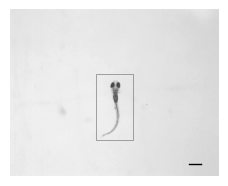

In [38]:
frame_n = bout_frame+15
img = frames[frame_n]
rot_im = img
### Make a lighter figure
out = cv2.addWeighted(rot_im, contrast, rot_im, 0, brightness)

# Create figure and axes
fig, ax = plt.subplots(figsize=(7*cm, 5*cm), facecolor='None')
ax.imshow(np.flip(out), alpha=0.9, cmap='gray', origin='upper') #plus 15 to see bend tail etc

ax.add_patch(
    patches.Rectangle(
        xy=(center_x-225/2, center_y-225/2),  # point of origin.
        width=225, height=400, linewidth=lw,
        color='gray', fill=False))

ax.axis('off')
ax.plot([1100, 1170], [950, 950], lw=lw*2, c='k')
# ax.text( 1100, 980, '1 mm', fontsize=f_size)
plt.tight_layout()

plt.savefig(figure_path/'bout_{}_tracked_frame.png'.format(bout), dpi = dpi)
plt.savefig(figure_path/'bout_{}_tracked_frame.pdf'.format(bout), dpi = dpi)

### Skeleton overlayed on fish to show angles

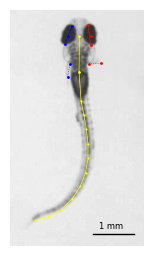

In [43]:
i = bout_frame + 15

# call addWeighted function. use beta = 0 to effectively only
out = cv2.addWeighted(frames[i], contrast, frames[i], 0, brightness)

plt.figure(figsize=(5*cm, 7.8*cm), facecolor='None')
plt.imshow(frames[i])
plt.imshow(out, origin='lower')

plt.plot([right_eye_anterior_x[i],right_eye_posterior_x[i]],[right_eye_anterior_y[i],right_eye_posterior_y[i]],'r', lw=lw)
plt.scatter(right_mid_eye_x[i],right_mid_eye_y[i],s=size,color='r', label='right eye')
plt.scatter(right_eye_anterior_x[i],right_eye_anterior_y[i], s=size,color='r')
plt.scatter(right_eye_posterior_x[i],right_eye_posterior_y[i], s=size,color='r')

plt.plot([left_eye_anterior_x[i],left_eye_posterior_x[i]],[left_eye_anterior_y[i],left_eye_posterior_y[i]],'b', lw=lw)
plt.scatter(left_mid_eye_x[i],left_mid_eye_y[i], s=size,color='b', label='left eye')
plt.scatter(left_eye_anterior_x[i],left_eye_anterior_y[i], s=size,color='b')
plt.scatter(left_eye_posterior_x[i],left_eye_posterior_y[i], s=size,color='b')

plt.scatter(left_fin_tip_x[i],left_fin_tip_y[i], s=size,color='b')
plt.scatter(left_fin_base_x[i],left_fin_base_y[i], s=size,color='b')
plt.scatter(right_fin_tip_x[i],right_fin_tip_y[i], s=size,color='r')
plt.scatter(right_fin_base_x[i],right_fin_base_y[i], s=size,color='r')
plt.plot([left_fin_tip_x[i], left_fin_base_x[i]],[left_fin_tip_y[i], left_fin_base_y[i]],'b' ,ls=':', lw=lw)
plt.plot([right_fin_tip_x[i], right_fin_base_x[i]],[right_fin_tip_y[i], right_fin_base_y[i]],'r' ,ls=':', lw=lw)

plt.scatter(body_x[i],body_y[i],s=size,color='yellow')
plt.scatter(mid_headx[i],mid_heady[i],s=size,color='yellow')
plt.plot([mid_headx[i], body_x[i]],[mid_heady[i], body_y[i]],'yellow', lw=lw)
plt.plot([tail_x_10[0,i], body_x[i]],[tail_y_10[0,i], body_y[i]],'yellow', lw=lw)

for i_seg in range(tail_x_10.shape[0]):
    plt.scatter(tail_x_10[i_seg,i],tail_y_10[i_seg,i],s=size, color='yellow', lw=lw)

for i_seg in range(tail_x_10.shape[0]-1):
    plt.plot([tail_x_10[i_seg,i], tail_x_10[i_seg+1,i]],[tail_y_10[i_seg,i], tail_y_10[i_seg+1,i]], color='yellow', lw=lw)
    

plt.ylim(200,600)
plt.xlim(750, 525)
plt.plot([540, 540+70], [220, 220], lw=lw*2, c='k')
plt.text(600, 230, '1 mm', fontsize=f_size)

plt.axis('off')

plt.savefig(figure_path/'keypoints_skeleton_{}.png'.format(i), dpi = dpi)
plt.savefig(figure_path/'keypoints_skeleton_{}.pdf'.format(i), dpi = dpi)

### Panel C: Frames throughout swims

In [44]:
chosen_inds = np.arange(4, 34, 2)
print (chosen_inds, len(chosen_inds))

[ 4  6  8 10 12 14 16 18 20 22 24 26 28 30 32] 15


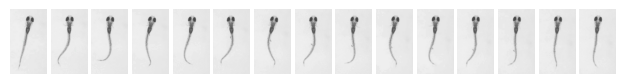

In [54]:

fig, axes = plt.subplots(1, len(chosen_inds), facecolor='None',figsize=(15.4*cm, 2.6*cm), sharex=False, sharey=False)
axes= axes.ravel()

for ax in range(len(chosen_inds)):
    frame_n = bout_frame+chosen_inds[ax]
    out = cv2.addWeighted(frames[frame_n], contrast, frames[frame_n], 0, brightness)
    axes[ax].imshow(out, alpha=0.9, cmap='gray', origin='lower') #plus 15 to see bend tail etc
    axes[ax].set_xlim(body_x[frame_n]+140, body_x[frame_n] - 140)
    axes[ax].set_ylim(body_y[frame_n] - 350, body_y[frame_n]+140)
    axes[ax].axis('off')
    axes[ax].axis('off')
 # Adjust subplots - ensure there's minimal space between them
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0)
# plt.tight_layout()
fig.savefig(figure_path/'bout_{}_{}_tp.png'.format(bout, labels_cat[bout_cat[bout]]), dpi = dpi)
fig.savefig(figure_path/'bout_{}_{}_tp.pdf'.format(bout, labels_cat[bout_cat[bout]]), dpi = dpi)

In [55]:
smoothed_l_eye = smoothed_l_eye - smoothed_l_eye[0]
smoothed_r_eye = smoothed_r_eye - smoothed_r_eye[0]

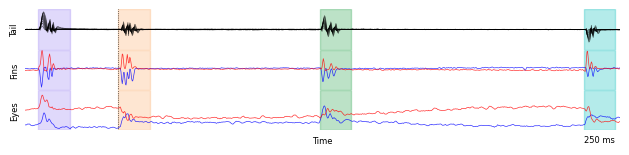

In [68]:
fig, axes = plt.subplots(3,1, figsize=(19.5*cm, 4*cm), facecolor='None', sharex=True)
axes = axes.ravel()

axes[0].plot(tail, lw=lw, c='k', alpha=0.6)
axes[0].set_ylim(-4,4)

axes[1].plot(smoothed_l_fin, lw=lw, c='blue', alpha=0.8, label='Left') 
axes[1].plot(smoothed_r_fin, lw=lw, c='red', alpha=0.8 , label='Right') 
axes[1].set_ylim(-1.8,1.8)

axes[2].plot(smoothed_l_eye, lw=lw, c='blue', alpha=0.8, label='Left') 
axes[2].plot(smoothed_r_eye, lw=lw, c='red', alpha=0.8 , label='Right')
axes[2].set_ylim(-12,12)

for ax in axes:
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axvline(bout_frame_n, c='k', ls=':', label ='Bout Start', lw=lw)
    
axes[0].set_ylabel('Tail', fontsize=f_size)
axes[1].set_ylabel('Fins', fontsize=f_size)
axes[2].set_ylabel('Eyes', fontsize=f_size)
axes[2].set_xlabel('Time', fontsize=f_size)

for indx, onset in enumerate(data['segments_on']):
    # axes[0].axvspan(onset, onset+50, color='gray', alpha=0.3)
    # axes[1].axvspan(onset, onset+50, color='gray', alpha=0.3)
    # axes[2].axvspan(onset, onset+50, color='gray', alpha=0.3)

    axes[0].axvspan(onset, onset+50, color=color[bout_cat[indx]], alpha=0.3)
    axes[1].axvspan(onset, onset+50, color=color[bout_cat[indx]], alpha=0.3)
    axes[2].axvspan(onset, onset+50, color=color[bout_cat[indx]], alpha=0.3)

axes[2].text(0.94, -0.3, '250 ms', transform=ax.transAxes, 
            size=f_size)
# axes[1].legend(loc='upper center', bbox_to_anchor=(0.75, 0.2), ncol=3, fontsize=f_size)

plt.xlim(bout_frame_n -150, bout_frame_n+800)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()

fig.savefig(figure_path/'bout_{}_{}_trace.png'.format(bout, labels_cat[bout_cat[bout]]), dpi = dpi)
fig.savefig(figure_path/'bout_{}_{}_trace.pdf'.format(bout, labels_cat[bout_cat[bout]]), dpi = dpi)

### Panel D: Fin Zoom 

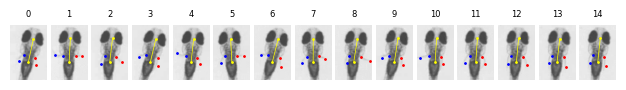

In [69]:

fig, axes = plt.subplots(1, len(chosen_inds), facecolor='None',figsize=(15.4*cm, 2.6*cm)) #, sharex=True, sharey=True)
axes= axes.ravel()

for ax in range(len(chosen_inds)):
    frame_n = bout_frame+chosen_inds[ax]
    out = cv2.addWeighted(frames[frame_n], contrast, frames[frame_n], 0, brightness)
    axes[ax].imshow(out, alpha=0.9, cmap='gray', origin='lower') #plus 15 to see bend tail etc
    
    axes[ax].scatter(body_x[frame_n], body_y[frame_n], c='yellow', s=size)
    axes[ax].scatter(mid_headx[frame_n], mid_heady[frame_n], c='yellow', s=size)
    axes[ax].plot([mid_headx[frame_n], body_x[frame_n]],[mid_heady[frame_n], body_y[frame_n]],'yellow', lw=lw)
    
    axes[ax].scatter(left_fin_tip_x[frame_n],left_fin_tip_y[frame_n], s=size,color='b')
    axes[ax].scatter(left_fin_base_x[frame_n],left_fin_base_y[frame_n], s=size,color='b')
    axes[ax].scatter(right_fin_tip_x[frame_n],right_fin_tip_y[frame_n], s=size,color='r')
    axes[ax].scatter(right_fin_base_x[frame_n],right_fin_base_y[frame_n], s=size,color='r')

    axes[ax].set_xlim(body_x[frame_n] + 50, body_x[frame_n]-50)
    axes[ax].set_ylim(body_y[frame_n] - 50, body_y[frame_n]+100)
    axes[ax].set_title(ax, fontsize=f_size)
    axes[ax].axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0)
# plt.tight_layout()
fig.savefig(figure_path/'bout_{}_{}_fins_img_zoom_tp.png'.format(bout, labels_cat[bout_cat[bout]]), dpi = dpi)
fig.savefig(figure_path/'bout_{}_{}_fins_img_zoom_tp.pdf'.format(bout, labels_cat[bout_cat[bout]]), dpi = dpi)

## Panel E: Fin Traces during bout

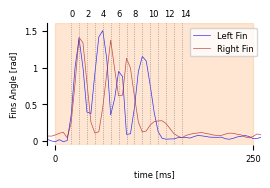

In [76]:
bout_frame_n = df.index[data['segments_on'][bout]]

fig, ax= plt.subplots(facecolor='None',figsize=(7*cm, 4*cm), sharex=True)

ax.plot((smoothed_l_fin*-1) +0.15, lw=lw, c='blue', alpha=0.8, label='Left Fin') 
ax.plot(smoothed_r_fin, lw=lw, c='firebrick', alpha=0.8 , label='Right Fin') 
ax.set_ylim(-0.05,1.6)

ax.set_xlabel('time [ms]', fontsize=f_size)
ax.set_ylabel('Fins Angle [rad]', fontsize=f_size)
ax.set_xticks([bout_frame_n, bout_frame_n+50])
ax.set_yticks([0,0.5, 1, 1.5])
ax.set_yticklabels([0,0.5, 1, 1.5], fontsize=f_size)
ax.set_xticklabels(['0', '250'], fontsize=f_size)

for indx, onset in enumerate(data['segments_on']):
    ax.axvspan(onset, onset+50, color=color[bout_cat[indx]], alpha=0.3)

# ax.legend(loc='upper left', bbox_to_anchor=(1, 1),ncol=1,fontsize=f_size)
ax.legend(fontsize=f_size)

# for ind,i in enumerate(chosen_inds):
#     frame_n = bout_frame_n+i
#     ax.axvline(frame_n, c='gray', ls=':', lw=lw)
#     plt.text(frame_n-0.5, 1.7, ind,rotation=0, fontsize=f_size)
for ind, i in enumerate(chosen_inds):
    frame_n = bout_frame_n + i
    ax.axvline(frame_n, c='gray', ls=':', lw=lw)
    
    # Label every second line
    if ind % 2 == 0:  # This will label lines at even indices; use `ind % 2 == 1` for odd indices
        plt.text(frame_n - 0.5, 1.7, ind, rotation=0, fontsize=f_size)


plt.xlim(bout_frame_n-2, bout_frame_n+52)
sns.despine(top=True, right=True, left=False, bottom=True)

plt.savefig(figure_path/'bout_{}_{}_fins_zoom_tp.png'.format(bout, labels_cat[bout_cat[bout]]), dpi = dpi)
plt.savefig(figure_path/'bout_{}_{}_fins_zoom_tp.pdf'.format(bout, labels_cat[bout_cat[bout]]), dpi = dpi)

## Panel F: Bout Categories

In [77]:
# Map the colors directly using the cluster indices
custom_palette = {cluster: color_bouts[cluster] for cluster in np.unique(features['cluster'])}

In [78]:
# Calculate normalized counts
# First, count the occurrences of each new_cluster within each fish_id
counts = features.groupby(['fish_id', 'cluster']).size().reset_index(name='count')
# Then, normalize these counts within each fish_id
total_counts = counts.groupby('fish_id')['count'].transform('sum')
counts['normalized_count'] = counts['count'] / total_counts

In [83]:
fig1 = 8.7
fig2 = 4.9

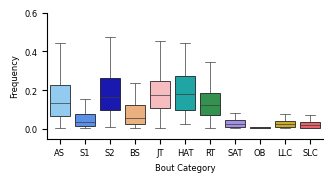

In [85]:
# Create a bar plot for normalized counts
fig, ax = plt.subplots(facecolor='None',figsize=(fig1*cm, fig2*cm))
sns.boxplot(data=counts, x='cluster', y='normalized_count', hue='cluster', legend=False,  palette=custom_palette, dodge=False, showfliers=False) 

# Adjust line widths for all elements of the boxplot
for i, artist in enumerate(ax.artists):
    artist.set_edgecolor('black')   # Set the edge color to ensure visibility
    artist.set_linewidth(lw)        # Set the width of the box edges to thinner

# Adjust lines for whiskers, caps, and medians
for line in ax.lines:
    line.set_linewidth(lw)

# Adjust the line width for the boxes
for box in ax.patches:
    # Set the edge color and line width for the box
    box.set_edgecolor('black')
    box.set_linewidth(lw)

plt.ylabel('Frequency', fontsize=f_size, c='k')

plt.xticks(np.arange(0,11,1), labels=labels_cat_short, rotation =0, fontsize=f_size, c='k')
plt.xlabel('Bout Category', fontsize=f_size, c='k')
plt.ylim(-0.05, 0.6)
plt.yticks(fontsize=f_size, c='k')

sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

fig.savefig(figure_path/ 'pooled_bout_cat_boxplot.pdf', dpi=dpi)
fig.savefig(figure_path/ 'pooled_bout_cat_boxplot.png', dpi=dpi)